In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import os
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic, ICRS
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor

#Data file
file = os.chdir("/home/abhi/Desktop/eROSITA/")

#Importing the data and model parameters
data = pd.read_excel("New  Variables and Transients.xlsx")
data1 = pd.read_csv("Vikas_737_parms.csv")
a_1 = data1["1"].to_numpy().reshape(-1,1)
a_2 = data1["2"].to_numpy().reshape(-1,1)
E_p = data1["3"].to_numpy().reshape(-1,1)
lum_x = data["Luminosity (ergs/sec)"].dropna().to_numpy().reshape(-1,1)
dist = data["Distance"].dropna().to_numpy().reshape(-1,1)
sr_class = data["Source Class"].dropna().to_numpy()
bp_rp = data["bp_rp"].dropna().to_numpy().reshape(-1,1)
Absolute_G = data["Absolute G"].dropna().to_numpy().reshape(-1,1)
Temp = data["Temp (Kelvin)"].dropna().to_numpy().reshape(-1,1)
lum_o = data["luminosity_GAIA (ergs/sec)"].dropna().to_numpy().reshape(-1,1)
radius = data["RADIUS"].dropna().to_numpy().reshape(-1,1)


#Checking the shapes
print("lum_x",np.shape(lum_x))
print("lum_o",np.shape(lum_o))
print("dist",np.shape(dist))
print("bp-rp",np.shape(bp_rp))
print("Temp", np.shape(Temp))
print("radius", np.shape(radius))
print("Absolute_G", np.shape(Absolute_G))

#Changing the elements to nan
lum_o[lum_o == "--"] = np.nan
Temp[Temp == "--"] = np.nan
bp_rp[bp_rp == "--"] = np.nan
radius[radius == "--"] = np.nan

#Checking the length of the array
print(len(radius))
print(len(dist))
print(len(Temp))
print(len(lum_o))

#Checking the source class
count = Counter(sr_class)
print(count)

#Class
class_1 = ["SS_IB", "YSO", "IB","IB_ACS", "CV", "LPV", "XRB"]

#Replacing sources by their numbers
sr_class_new = sr_class

sr_class_new[sr_class_new  == "SS_IB"] = 0
sr_class_new[sr_class_new  == "YSO"] = 1
sr_class_new[sr_class_new  == "IB"] = 2
sr_class_new[sr_class_new  == "IB_ACS"] = 3
sr_class_new[sr_class_new  == "CV"] = 4
sr_class_new[sr_class_new  == "LPV"] = 5
sr_class_new[sr_class_new  == "XRB"] = 6


# Random Forest classification
rf_cl = RandomForestClassifier(n_estimators = 890, class_weight="balanced", random_state=42)
target = np.array(sr_class_new, dtype=int)

#Data and Standardization
data_1_obs = np.column_stack((lum_x,dist,Absolute_G,bp_rp,lum_o))#a1,a2,Ep,o_period)) = how to adjust the nan vals
data_1_pars = np.column_stack((a_1,a_2,E_p))
scalar = RobustScaler()
data_1_scaled = scalar.fit_transform(data_1_obs)

#Imputing
imputer = SimpleImputer(strategy='most_frequent')
data_1_scaled_t = imputer.fit_transform(data_1_scaled)

#SMOTE
smote = SMOTE(random_state=42,k_neighbors=2)
smt = SMOTETomek(random_state=42,smote=smote)
adasyn = ADASYN(random_state=42,n_neighbors=2) 

#Cleaning
# data_1_scaled_clean = data_1_scaled[~np.isnan(data_1_scaled).any(axis=1)]
# target_clean = target[~np.isnan(data_1_scaled).any(axis=1)]
data_1_scaled_s , target_s = smt.fit_resample(data_1_scaled_t,target)

reg_a1 = KNeighborsRegressor(n_neighbors=1).fit(data_1_scaled_t, a_1)
reg_a2 = KNeighborsRegressor(n_neighbors=1).fit(data_1_scaled_t, a_2)
reg_ep = KNeighborsRegressor(n_neighbors=1).fit(data_1_scaled_t, E_p)

a1_resampled = reg_a1.predict(data_1_scaled_s)
a2_resampled = reg_a2.predict(data_1_scaled_s)
Ep_resampled = reg_ep.predict(data_1_scaled_s)

data_final = X_final = np.hstack([data_1_scaled_s, a1_resampled.reshape(-1, 1),a2_resampled.reshape(-1, 1),Ep_resampled.reshape(-1, 1)])

#Test_Train Data Set
X_train, X_test, y_train, y_test = train_test_split(data_final, target_s, test_size=0.15, random_state=42,stratify=target_s)

#RF classification
y_rf_cl = rf_cl.fit(X_train,y_train)
print(y_rf_cl)
print(len(X_train))
print(len(y_train))
#print(data_1_scaled_s)

lum_x (735, 1)
lum_o (735, 1)
dist (735, 1)
bp-rp (735, 1)
Temp (734, 1)
radius (735, 1)
Absolute_G (735, 1)
735
735
734
735
Counter({'SS_IB': 417, 'IB': 110, 'YSO': 105, 'IB_ACS': 50, 'CV': 38, 'LPV': 12, 'XRB': 3})


/home/abhi/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/abhi/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


RandomForestClassifier(class_weight='balanced', n_estimators=890,
                       random_state=42)
2418
2418


In [2]:
accy = []
n = [100, 250, 500,750,850,880,890,900,950,1000]
for i in n: 
    rf_cl = RandomForestClassifier(n_estimators=i, class_weight="balanced", random_state=42)
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accy.append(acc)
    print(f"n_estimators = {i}, accuracy = {acc:.4f}")

n_estimators = 100, accuracy = 0.9087
n_estimators = 250, accuracy = 0.9087
n_estimators = 500, accuracy = 0.9133
n_estimators = 750, accuracy = 0.9157
n_estimators = 850, accuracy = 0.9180
n_estimators = 880, accuracy = 0.9204
n_estimators = 890, accuracy = 0.9204
n_estimators = 900, accuracy = 0.9157
n_estimators = 950, accuracy = 0.9157
n_estimators = 1000, accuracy = 0.9110


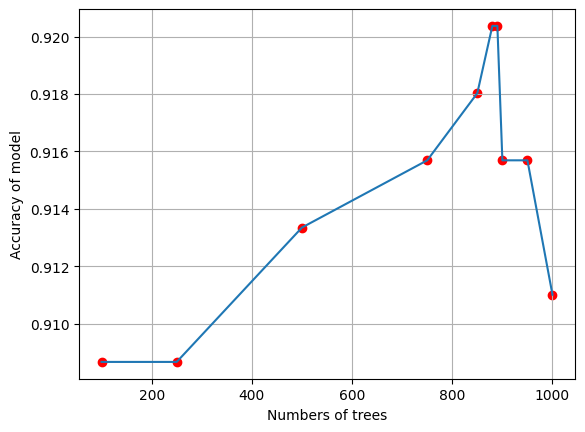

In [3]:
##Plotting the graph
plot.plot(n,accy)
plot.scatter(n,accy, color = "red")
plot.xlabel("Numbers of trees")
plot.ylabel("Accuracy of model")
plot.xlim()
plot.grid()

In [4]:
y_rf_cl

RandomForestClassifier(class_weight='balanced', n_estimators=890,
                       random_state=42)

In [5]:
#Predict
lum_x_ = 3.32e31
dist_ = 253.92
bp_rp_ = 1.2
Absolute_G_ = 8
lum_o_ = 23.835
a_1_ = -1   # Not needed, you predict these
a_2_ = 1
E_p_ = 0.8

# Step 1: Create observational feature array (only 5 features)
source_obs = np.array([[lum_x_, dist_, Absolute_G_, bp_rp_, lum_o_]])
source_obs_scaled = scalar.transform(source_obs)

a1_pred = reg_a1.predict(source_obs_scaled)
a2_pred = reg_a2.predict(source_obs_scaled)
Ep_pred = reg_ep.predict(source_obs_scaled)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

# Step 6: Predict class
result = y_rf_cl.predict(source_final)
print("The new source belongs to the class:", class_1[int(result[0])])

The new source belongs to the class: SS_IB


In [6]:
#Predict
lum_x_ = 2.9e34
dist_ = 2605
bp_rp_ = 0.74
Absolute_G_ = -5.72
lum_o_ = 10200
Temp_ = 6000
a_1_ = -2   
a_2_ = 1
E_p_ = 1

# Step 1: Create observational feature array (only 5 features)
source_obs = np.array([[lum_x_, dist_, Absolute_G_, bp_rp_, lum_o_]])
source_obs_scaled = scalar.transform(source_obs)

a1_pred = reg_a1.predict(source_obs_scaled)
a2_pred = reg_a2.predict(source_obs_scaled)
Ep_pred = reg_ep.predict(source_obs_scaled)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

# Step 6: Predict class
result = y_rf_cl.predict(source_final)
print("The new source belongs to the class:", class_1[int(result[0])])

The new source belongs to the class: SS_IB


In [7]:
importances = rf_cl.feature_importances_
for name, val in zip(["lum_x", "dist", "Absolute_G", "bp_rp", "lum_o","a_1","a_2","E_p"], importances):
    print(f"{name}: {val:.3f}")

lum_x: 0.169
dist: 0.153
Absolute_G: 0.195
bp_rp: 0.164
lum_o: 0.164
a_1: 0.094
a_2: 0.027
E_p: 0.033


In [8]:
y_pred = y_rf_cl.predict(X_test) 
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print("Confusion Matrix is as follows:")
print(cm)
print(class_1)

Confusion Matrix is as follows:
[[35  8  7  3  1  3  1]
 [ 1 59  0  0  1  0  0]
 [ 2  1 55  0  0  2  0]
 [ 0  1  1 59  0  0  0]
 [ 0  0  0  0 62  0  0]
 [ 0  0  2  0  0 60  0]
 [ 0  0  0  0  0  0 63]]
['SS_IB', 'YSO', 'IB', 'IB_ACS', 'CV', 'LPV', 'XRB']


In [9]:
print(classification_report(y_test, y_pred,target_names= class_1))

              precision    recall  f1-score   support

       SS_IB       0.92      0.60      0.73        58
         YSO       0.86      0.97      0.91        61
          IB       0.85      0.92      0.88        60
      IB_ACS       0.95      0.97      0.96        61
          CV       0.97      1.00      0.98        62
         LPV       0.92      0.97      0.94        62
         XRB       0.98      1.00      0.99        63

    accuracy                           0.92       427
   macro avg       0.92      0.92      0.91       427
weighted avg       0.92      0.92      0.92       427



In [10]:
#Using cross_validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model with accuracy scoring
scores = cross_val_score(rf_cl,data_final,target_s, cv=cv, scoring='accuracy')

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [0.89455185 0.88400703 0.91739895 0.91036907 0.91036907]
Mean accuracy: 0.9033391915641475


In [11]:
#Using the model on 2.9k eROSITA sources
df = pd.read_csv("e-ROSITA NEW RESULTS - EROSITA+GAIA (1).csv")
df1 = pd.read_csv("2164_parms.txt")
lum_x_1 = df["Luminosity (ergs/sec)"].dropna().to_numpy()
dist_1 = df["Distance (pc)"].dropna().to_numpy()
bp_rp_1 = df["bp_rp"].dropna().to_numpy()
Absolute_G_1 = df["Absolute G"].dropna().to_numpy()
Temp_1 = df["Temp (Kelvin)"].dropna().to_numpy()
lum_o_1 = df["luminosity_GAIA (ergs/sec)"].dropna().to_numpy()
radius_1 = df["RADIUS"].dropna().to_numpy()
a_1_1 = df1["1"].to_numpy()
a_2_1 = df1["2"].to_numpy()
E_p_1 = df1["3"].to_numpy()

#Changing the elements to nan
lum_o_1[lum_o_1 == "--"] = np.nan
Temp_1[Temp_1 == "--"] = np.nan
bp_rp_1[bp_rp_1 == "--"] = np.nan
radius_1[radius_1 == "--"] = np.nan

#Stacking the data
source_obs = np.column_stack((lum_x_1, dist_1, Absolute_G_1, bp_rp_1, lum_o_1))
source_obs_scaled = scalar.transform(source_obs) 
source_obs_t = imputer.transform(source_obs_scaled)

a1_pred = reg_a1.predict(source_obs_t)
a2_pred = reg_a2.predict(source_obs_t)
Ep_pred = reg_ep.predict(source_obs_t)

source_final = np.hstack([source_obs_scaled,a1_pred.reshape(-1,1),a2_pred.reshape(-1,1),Ep_pred.reshape(-1,1)])

#Final Predict class
result = y_rf_cl.predict(source_final)
#print("The new source belongs to the class:", class_1[int(result[0])])

final_class = []

for i in result:
    final_class.append(class_1[int(i)])
print(final_class)

['SS_IB', 'YSO', 'IB', 'IB', 'CV', 'IB', 'CV', 'IB_ACS', 'IB', 'IB', 'SS_IB', 'IB', 'CV', 'SS_IB', 'IB', 'SS_IB', 'IB', 'CV', 'CV', 'CV', 'SS_IB', 'SS_IB', 'CV', 'IB', 'SS_IB', 'CV', 'CV', 'SS_IB', 'CV', 'SS_IB', 'CV', 'IB', 'SS_IB', 'YSO', 'SS_IB', 'CV', 'IB_ACS', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'IB', 'CV', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'CV', 'SS_IB', 'SS_IB', 'CV', 'LPV', 'IB_ACS', 'IB', 'SS_IB', 'SS_IB', 'IB', 'IB_ACS', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'LPV', 'IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'LPV', 'SS_IB', 'IB', 'SS_IB', 'IB', 'IB', 'SS_IB', 'CV', 'IB', 'SS_IB', 'SS_IB', 'SS_IB', 'SS_IB', 'IB', 'IB', 'IB', 'CV', 'IB', 'IB', 'IB', 'XRB', 'SS_IB', 'CV', 'CV', 'CV', 'CV', 'SS_IB', 'CV', 'CV', 'CV', 'CV', 'SS_IB', 'SS_IB', 'SS_IB', 'CV', 'CV', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'SS_IB', 'SS_IB', 'IB', 'SS_IB', 'IB', 'YSO', 'LPV', 'SS_IB', 'SS_IB', 'SS_IB', 'LPV', 'SS_IB', 'L

In [12]:
Counter(final_class)

Counter({'SS_IB': 1154,
         'IB': 477,
         'IB_ACS': 223,
         'YSO': 203,
         'CV': 57,
         'LPV': 47,
         'XRB': 4})

In [13]:
#Checking with Simbad classification
data_2 = pd.read_csv("e-ROSITA NEW RESULTS - EROSITA+GAIA (1).csv")
sr_class_vikas = data_2["New source class"]
Counter(sr_class_vikas)

Counter({'SS_IB': 1306,
         'IB': 417,
         'YSO': 252,
         'Not_known': 129,
         'CV': 49,
         'LPV': 7,
         'XRB': 5})

In [19]:
##Creating the csv file

df_final = df
df_final["a1"] = a_1_1
df_final["a2"] = a_2_1
df_final["E_p"] = E_p_1
df_final["Abhishek's Classification"] = final_class

df_final.to_csv("Final Classificaion Result")